In [1]:
from __future__ import absolute_import, division, print_function

import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import cv2 as cv

from scipy import misc
from PIL import Image
from collections import defaultdict
from io import BytesIO
import telegram
from telegram.ext import (Updater, CommandHandler, MessageHandler, Filters,
                          ConversationHandler)
import logging

In [2]:
# Функции для работы с изображением для send_prediction_on_photo
def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image


def load_image_telegram(path, image_size=(256, 256), preserve_aspect_ratio=True):
  img = plt.imread(path, "jpg")
  img = img.astype(np.float32)[np.newaxis, ...] / 255.
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img


def show_n(images, titles=('',)):
    n = len(images)
    image_sizes = [image.shape[1] for image in images]
    w = (image_sizes[0] * 6) // 320
    plt.figure(figsize=(w  * n, w))
    gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
    for i in range(n):
        plt.subplot(gs[i])
        plt.imshow(images[i][0], aspect='equal')
        plt.axis('off')
        plt.title(titles[i] if len(titles) > i else '')
    plt.show()

In [3]:
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)
first_image_file = defaultdict(lambda: None)
style_image_file = defaultdict(lambda: None)
token = '796601714:AAGq4PEKHRr6AnV81SOi5zmM17WkHNYbKpM'
res_size = (256, 256)
HELP = 1
PHOTO = 2

In [4]:

def start(bot, update):
    bot.send_message(chat_id=update.message.chat_id, 
        text='Привет! Я НейроБот. Я переношу стили.\n'
        'Чтобы перенести стиль, дайте мне две картинки (контент и стиль).\n'
        'Используйте /help чтобы вывести подсказку, /cancel для конца беседы.')

def bot_help(bot, update):
    ch_id = update.message.chat_id
    if first_image_file[ch_id]:
        bot.send_message(chat_id=ch_id, text='Докинь стиль :).')
    else:
        bot.send_message(chat_id=ch_id, text='Докинь контент, а затем стиль.')
    return HELP

def cancel(bot, update):
    user = update.message.from_user
    print(f"User {update.message.chat_id} canceled the conversation.")
    bot.send_message(chat_id=update.message.chat_id, text='Ну ты это, заходи если что :).')

    return ConversationHandler.END

def error(bot, update):
    print(f"Update {update} caused error {context.error}")

def send_prediction_on_photo(bot, update):
    chat_id = update.message.chat_id
    print("Got image from {}\n".format(chat_id))

    image_info = update.message.photo[-1].file_id
    image_file = bot.get_file(image_info)

    print(image_info)
    print(image_file)

    if first_image_file[chat_id]:
        first_image_file[chat_id].download(f"./temp/content_{chat_id}.jpg")
        del first_image_file[chat_id]
        
        bot.send_message(chat_id=update.message.chat_id, text="Ням!")
        style_image_file[chat_id] = image_file
        style_image_file[chat_id].download(f"./temp/style_{chat_id}.jpg")
        del style_image_file[chat_id]
        
        content_image = load_image_telegram(f"./temp/content_{chat_id}.jpg", image_size=res_size)
        style_image = load_image_telegram(f"./temp/style_{chat_id}.jpg", image_size=res_size)
        
        show_n([content_image, style_image], titles=['Original content image', 'Style image'])
        outputs = hub_module(content_image, style_image)
        os.remove(f"./temp/content_{chat_id}.jpg")
        os.remove(f"./temp/style_{chat_id}.jpg")
    
        output = (outputs[0].numpy() * 255).astype(np.uint8)
        bot.send_message(chat_id=update.message.chat_id, text="Готово!")
        show_n([output], titles=['Result image'])
        
        res = Image.fromarray(output[0])
        res.save(f"./temp/res_{chat_id}.jpg")
        # теперь отправим назад фото
        output_stream = BytesIO()
        res.save(output_stream, format='png')
        output_stream.seek(0)
        bot.send_photo(chat_id, photo=output_stream)
        print("Sent Photo to user")
        output_stream.close()
        os.remove(f"./temp/res_{chat_id}.jpg")
        
    else:
        bot.send_message(chat_id=update.message.chat_id, text="Ням!")
        first_image_file[chat_id] = image_file


C:\Users\vasil\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: TelegramDeprecationWarning: Old Handler API is deprecated - see https://git.io/fxJuV for details
  if __name__ == '__main__':


Got image from 494322185

AgACAgIAAxkBAAIB_V5AAAGN6YexWIf45IwmJQFXyTIJZQACHq8xG5IGAAFKwBDHaL92GXuiYssOAAQBAAMCAAN4AAPwCQIAARgE
{'file_id': 'AgACAgIAAxkBAAIB_V5AAAGN6YexWIf45IwmJQFXyTIJZQACHq8xG5IGAAFKwBDHaL92GXuiYssOAAQBAAMCAAN4AAPwCQIAARgE', 'file_size': 74543, 'file_path': 'https://api.telegram.org/file/bot796601714:AAGq4PEKHRr6AnV81SOi5zmM17WkHNYbKpM/photos/file_135.jpg'}
Got image from 494322185

AgACAgIAAxkBAAIB_15AAAGTTXS1n_QnuQd7qWO9KN0QSQACH68xG5IGAAFKe1co8j0FZ7VDSssOAAQBAAMCAAN5AAMfBwIAARgE
{'file_id': 'AgACAgIAAxkBAAIB_15AAAGTTXS1n_QnuQd7qWO9KN0QSQACH68xG5IGAAFKe1co8j0FZ7VDSssOAAQBAAMCAAN5AAMfBwIAARgE', 'file_size': 94733, 'file_path': 'https://api.telegram.org/file/bot796601714:AAGq4PEKHRr6AnV81SOi5zmM17WkHNYbKpM/photos/file_136.jpg'}


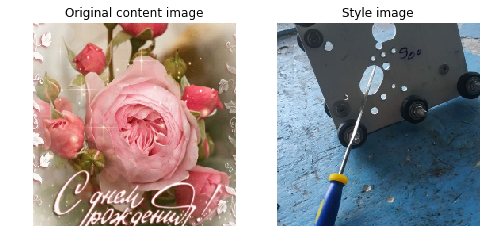

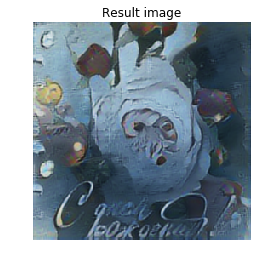

Sent Photo to user


In [ ]:
if __name__ == '__main__':
# Включим самый базовый логгинг, чтобы видеть сообщения об ошибках
    logging.basicConfig(
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        level=logging.INFO)
    # используем прокси, так как без него у меня ничего не работало.
    # если есть проблемы с подключением, то попробуйте убрать прокси или сменить на другой
    # прокси ищется в гугле как "socks4 proxy"
    updater = Updater(token=token,  request_kwargs={'proxy_url': 'socks5h://163.172.152.192:1080'})

    dp = updater.dispatcher
    dp.add_handler(CommandHandler("start", start))
    dp.add_handler(CommandHandler("help", bot_help))
    dp.add_handler(CommandHandler("cancel", cancel))
    dp.add_handler(MessageHandler(Filters.photo, send_prediction_on_photo))


    dp.add_error_handler(error)

    updater.start_polling()
    updater.idle()
